In [429]:
# Multiclass Classification

import torch
from torch import nn
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_blobs

NUM_CLASSES = 4
NUM_FEATURES = 2
RANDOM_SEED = 42

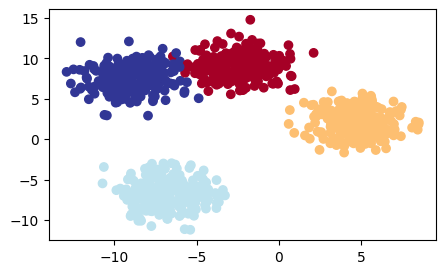

In [430]:
# Preparing data
x_blob, y_blob = make_blobs(n_samples=1000,n_features=NUM_FEATURES,centers=NUM_CLASSES, cluster_std=1.5, random_state=RANDOM_SEED)

x_blob = torch.from_numpy(x_blob).type(torch.float)
y_blob = torch.from_numpy(y_blob).type(torch.LongTensor)

X_train, X_test, y_train, y_test = train_test_split(x_blob, y_blob, test_size=0.2, random_state=RANDOM_SEED)

plt.figure(figsize=(5,3))
plt.scatter(x_blob[:,0],x_blob[:,1], c = y_blob, cmap=plt.cm.RdYlBu)

In [431]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [432]:
class BlobModel(nn.Module):
    def __init__(self, input_features, output_features, hidden_units = 8):
        super().__init__()

        self.linear_layer_stack = nn.Sequential(
            nn.Linear(in_features=input_features, out_features=hidden_units),
            # nn.ReLU(),
            nn.Linear(in_features=hidden_units, out_features=hidden_units),
            # nn.ReLU(),
            nn.Linear(in_features=hidden_units, out_features=output_features)
        )

    def forward(self, x : torch.Tensor) -> torch.Tensor:
        return self.linear_layer_stack(x)

In [433]:
modelv0 = BlobModel(input_features=2, output_features=4).to(device)

modelv0

BlobModel(
  (linear_layer_stack): Sequential(
    (0): Linear(in_features=2, out_features=8, bias=True)
    (1): Linear(in_features=8, out_features=8, bias=True)
    (2): Linear(in_features=8, out_features=4, bias=True)
  )
)

In [434]:
modelv0.state_dict()

OrderedDict([('linear_layer_stack.0.weight',
              tensor([[ 0.5406,  0.5869],
                      [-0.1657,  0.6496],
                      [-0.1549,  0.1427],
                      [-0.3443,  0.4153],
                      [ 0.6233, -0.5188],
                      [ 0.6146,  0.1323],
                      [ 0.5224,  0.0958],
                      [ 0.3410, -0.0998]])),
             ('linear_layer_stack.0.bias',
              tensor([ 0.5451,  0.1045, -0.3301,  0.1802, -0.3258, -0.0829, -0.2872,  0.4691])),
             ('linear_layer_stack.1.weight',
              tensor([[-0.2791, -0.1630, -0.0998, -0.2126,  0.0334, -0.3492,  0.3193, -0.3003],
                      [ 0.2730,  0.0588, -0.1148,  0.2185,  0.0551,  0.2857,  0.0387, -0.1115],
                      [ 0.0950, -0.0959,  0.1488,  0.3157,  0.2044, -0.1546,  0.2041,  0.0633],
                      [ 0.1795, -0.2155, -0.3500, -0.1366, -0.2712,  0.2901,  0.1018,  0.1464],
                      [ 0.1118, -0.0062,  0.276

In [435]:
loss_fn = nn.CrossEntropyLoss()

optimizer = torch.optim.SGD(params=modelv0.parameters(), lr = 0.01)

In [436]:
X_test.dtype

torch.float32

In [437]:
X_test = X_test.to(dtype=torch.float)
modelv0.eval()
with torch.inference_mode():
    test_logits = modelv0(X_test)
    pred_probs = torch.softmax(test_logits, dim = 1)


In [438]:
pred_probs[:5]

tensor([[0.1872, 0.2918, 0.1495, 0.3715],
        [0.2824, 0.0149, 0.2881, 0.4147],
        [0.3380, 0.0778, 0.4854, 0.0989],
        [0.2118, 0.3246, 0.1889, 0.2748],
        [0.1945, 0.0598, 0.1506, 0.5951]])

In [439]:
test_preds = torch.argmax(pred_probs, dim=1)
test_preds[:5], torch.argmax(test_logits, dim=1)[:5]

(tensor([3, 3, 2, 1, 3]), tensor([3, 3, 2, 1, 3]))

In [440]:
def accuracy(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item()
    return (correct/len(y_pred))*100

In [441]:
# Writing a training and testing loop

torch.manual_seed(RANDOM_SEED)
epochs = 1001

for epoch in range(epochs):
    modelv0.train()
    train_logits = modelv0(X_train.to(device))
    train_preds = torch.softmax(train_logits, dim=1).argmax(dim=1)
    loss = loss_fn(train_logits, y_train.to(device))
    acc = accuracy(y_true=y_train, y_pred=train_preds)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    modelv0.eval()
    with torch.inference_mode():
        test_logits = modelv0(X_test.to(device))
        test_preds = torch.softmax(test_logits, dim=1).argmax(dim=1)
        t_loss = loss_fn(test_logits, y_test.to(device))
        t_acc = accuracy(y_true=y_test, y_pred=test_preds)

    if epoch%10==0:
        print(f"Epoch : {epoch}, loss : {loss:.4f}, acc : {acc:2f}%, t_loss : {t_loss:.4f}, t_acc : {t_acc:.2f}%")

Epoch : 0, loss : 1.0432, acc : 65.500000%, t_loss : 0.9634, t_acc : 71.00%
Epoch : 10, loss : 0.6369, acc : 79.500000%, t_loss : 0.6122, t_acc : 88.00%
Epoch : 20, loss : 0.4694, acc : 97.750000%, t_loss : 0.4586, t_acc : 98.00%
Epoch : 30, loss : 0.3734, acc : 98.500000%, t_loss : 0.3677, t_acc : 99.00%
Epoch : 40, loss : 0.3101, acc : 98.625000%, t_loss : 0.3066, t_acc : 99.00%
Epoch : 50, loss : 0.2649, acc : 98.875000%, t_loss : 0.2623, t_acc : 99.00%
Epoch : 60, loss : 0.2308, acc : 98.875000%, t_loss : 0.2285, t_acc : 99.50%
Epoch : 70, loss : 0.2043, acc : 99.125000%, t_loss : 0.2020, t_acc : 99.50%
Epoch : 80, loss : 0.1831, acc : 99.125000%, t_loss : 0.1806, t_acc : 99.00%
Epoch : 90, loss : 0.1658, acc : 99.125000%, t_loss : 0.1630, t_acc : 99.00%
Epoch : 100, loss : 0.1515, acc : 99.125000%, t_loss : 0.1484, t_acc : 99.00%
Epoch : 110, loss : 0.1394, acc : 99.125000%, t_loss : 0.1361, t_acc : 99.00%
Epoch : 120, loss : 0.1292, acc : 99.125000%, t_loss : 0.1256, t_acc : 99.0

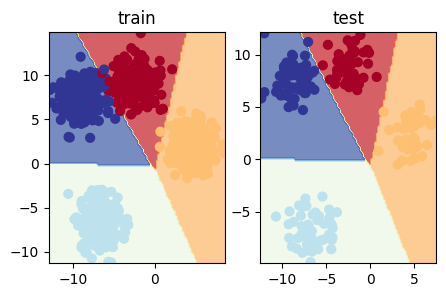

In [442]:
# Plotting the decision boundary
from helper_functions import plot_decision_boundary

plt.figure(figsize=(5,3))
plt.subplot(1,2,1)
plt.title("train")
plot_decision_boundary(modelv0, X_train, y_train)

plt.subplot(1,2,2)
plt.title("test")
plot_decision_boundary(modelv0, X_test, y_test)